# SageMaker Bring Your Own Script Using SageMaker PyTorch Framework Container
### Demo is modified from TorchVision Instance Segmentation Finetuning Tutorial (https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

For this tutorial, we will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model in the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/). It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

**As pycocotools is not included in pre-built PyTorch framework containers (https://github.com/aws/deep-learning-containers/tree/master/pytorch), we need to list it in `requirements.txt` in folder `scripts`**

In [1]:
%%sh

# !pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-7pq9h3yw
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=103378 sha256=c9d65171752e3a46e83eed3b71647c7817bef934012e7a29bc35c929f8757c4b
  Stored in directory: /tmp/pip-ephem-wheel-cache-t733taik/wheels/25/c1/63/8bee2969883497d2785c9bdbe4e89cae5efc59521553d528bf
Successfully built pycocotools


  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-7pq9h3yw
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### First, download and extract the data 

The dataset is present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [2]:
%%sh

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip
rm PennFudanPed.zip

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: PennFudanPed/Annotation/FudanPed00007.txt  
  inflating: PennFudanPed/Annotation/FudanPed00008.txt  
  inflating: PennFudanPed/Annotation/FudanPed00009.txt  
  inflating: PennFudanPed/Annotation/FudanPed00010.txt  
  inflating: PennFudanPed/Annotation/FudanPed00011.txt  
  inflating: PennFudanPed/Annotation/FudanPed00012.txt  
  inflating: PennFudanPed/Annotation/FudanPed00013.txt  
  inflating: PennFudanPed/Annotation/FudanPed00014.txt  
  inflating: PennFudanPed/Annotation/FudanPed00015.txt  
  i

--2021-11-23 14:18:48--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

     0K .......... .......... .......... .......... ..........  0% 3.73M 14s
    50K .......... .......... .......... .......... ..........  0% 10.1M 9s
   100K .......... .......... .......... .......... ..........  0%  217M 6s
   150K .......... .......... .......... .......... ..........  0% 10.3M 6s
   200K .......... .......... .......... .......... ..........  0%  154M 5s
   250K .......... .......... .......... .......... ..........  0%  209M 4s
   300K .......... .......... .......... .......... ..........  0%  330M 4s
   350K .......... .......... .......... .......... ..........  0%  339M 3s
   400K .....

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

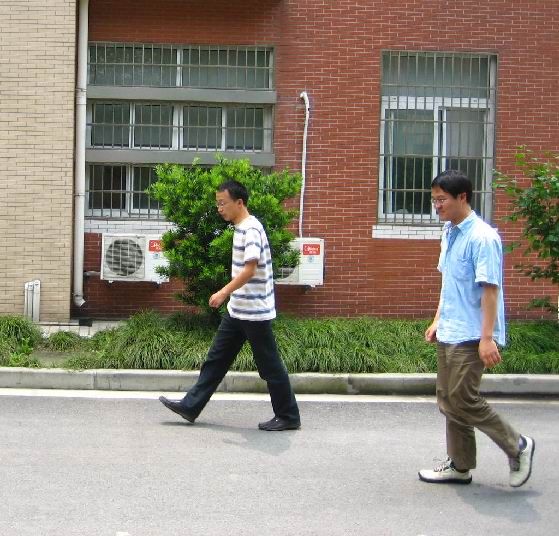

In [2]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

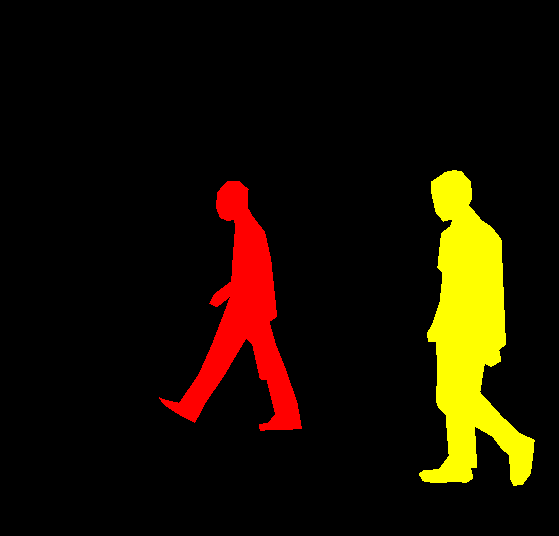

In [3]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask = mask.convert("P")
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

So each image has a corresponding segmentation mask, where each color correspond to a different instance. 

### **Now upload the dataset to an S3 bucket.**
First, let's import some libaries and define IAM role

In [4]:
import boto3
import re
import os
import numpy as np
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
sess = sagemaker.Session()

bucket = 'object-detection-demo-rubicon'  # Put your bucket name here
prefix_input = 'pytorch-framework/data'
prefix_output = 'pytorch-framework/output'

Upload the data to S3

In [5]:
uploads = sess.upload_data(path='PennFudanPed', bucket=bucket, key_prefix=prefix_input)
print('Dataset is uploaded to: {}'.format(uploads))

Dataset is uploaded to: s3://object-detection-demo-rubicon/pytorch-framework/data


## Prepare PyTorch scripts

### Write a torch.utils.data.Dataset class for the dataset
**The torch.utils.data.Dataset class in original tutorial will be moved to a script called `train.py` in folder `scripts`**

### Defining your model

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image. Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small. So we will finetune from a pretrained model. Here we want to also compute the instance segmentation masks, so we will be using Mask R-CNN.

**The model definition in original tutorial is also moved into `./scripts/train.py`**

### Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

**Let's copy those files (and their dependencies) to our `script` folder.** 

In [9]:
%%sh

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../scripts/
cp references/detection/transforms.py ../scripts/
cp references/detection/coco_eval.py ../scripts/
cp references/detection/engine.py ../scripts/
cp references/detection/coco_utils.py ../scripts/

Cloning into 'vision'...
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


**I modified function `train_one_epoch` in `engine.py` to return `loss_value` as well, so that we can use it as an objective matrix in SageMaker automatic hyperparameter optermization.**

**In `engine.py`, I also added `if torch.cuda.is_available():` in line 87, so as to run the demo on CPU.**

Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied. 

**These helper functions are moved to `train.py` as well**

### To put everything together, in folder "scripts" we wrote a train.py script where the main function (if __name__=='__main__':) locates. This will be the entrypoint for SageMaker training

In [6]:
!pygmentize ./scripts/train.py

import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

from torch.optim.lr_scheduler import StepLR

import argparse
import logging
import sys
import json

# Setup logger to write necessary logs to CloudWatch
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


"""
Write a torch.utils.data.Dataset class for the dataset
By default, the dataset returns a `PIL.Image` and a dictionary containing several fields, including `boxes`, `labels` and `masks`.
"""
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting 

## SageMaker training & automatic hyperparameter tuning

Now we'll define a SageMaker Pytorch estimator passing in the Pytorch script, IAM role, hyperparameters and hardware configurations.

### Test the training code locally

To test the training code locally to make sure everything works, specify `sess = sagemaker.LocalSession()` and `instance_type = "local"`. Since the dataset used in this demo is not large, I tested the code locally on the whole dataset. However, we only recommend you to do this type of local testing on a very small portion of your data. 

In [6]:
from sagemaker.pytorch import PyTorch

sess = sagemaker.LocalSession()

hyperparameters = {"num-epochs": 1}

estimator = PyTorch(
    entry_point = "train.py",
    source_dir = 'scripts',
    role = role,
    framework_version = "1.7.1",
    py_version = "py3",
    instance_count = 1,
    instance_type = "local",
    output_path = "s3://{}/{}".format(bucket, prefix_output),
    hyperparameters = hyperparameters,
    sagemaker_session = sess)

In [8]:
estimator.fit({'training': uploads})

Creating ufw6u3lcfx-algo-1-2j3ka ... 
Creating ufw6u3lcfx-algo-1-2j3ka ... done
Attaching to ufw6u3lcfx-algo-1-2j3ka
ufw6u3lcfx-algo-1-2j3ka | 2021-11-24 21:15:48,718 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
ufw6u3lcfx-algo-1-2j3ka | 2021-11-24 21:15:48,720 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
ufw6u3lcfx-algo-1-2j3ka | 2021-11-24 21:15:48,729 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
ufw6u3lcfx-algo-1-2j3ka | 2021-11-24 21:15:48,732 sagemaker_pytorch_container.training INFO     Invoking user training script.
ufw6u3lcfx-algo-1-2j3ka | 2021-11-24 21:15:48,861 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
ufw6u3lcfx-algo-1-2j3ka | /opt/conda/bin/python3.6 -m pip install -r requirements.txt
ufw6u3lcfx-algo-1-2j3ka | Collecting git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI (from -r requirem

### Set up hyperparameter tuning job

Now that we have prepared the dataset and the script, we are ready to train models. Before we do that, one thing to note is there are many hyperparameters that can dramtically affect the performance of the trained models. For example, learning rate, batch size, number of epochs, etc. Since which hyperparameter setting can lead to the best result depends on the dataset as well, it is almost impossible to pick the best hyperparameter setting without searching for it. Using SageMaker Automatic Model Tuning, we can create a hyperparameter tuning job to search for the best hyperparameter setting in an automated and effective way.

In this example, we are using SageMaker Python SDK to set up and manage a hyperparameter tuning job. Specifically, we specify a range, or a list of possible values in the case of categorical hyperparameters, for each of the hyperparameter that we plan to tune. The hyperparameter tuning job will automatically launch multiple training jobs with different hyperparameter settings, evaluate results of those training jobs based on a predefined "objective metric", and select the hyperparameter settings for future attempts based on previous results. For each hyperparameter tuning job, we will give it a budget (max number of training jobs) and it will complete once that many training jobs have been executed.

In [9]:
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

sess = sagemaker.Session()

# these are hyperparameters that won't be tuned
hyperparameters = {"num-epochs": 1,
                   "test-batch-size": 1,
                   "momentum": 0.9}

# define a PyTorch estimator
estimator = PyTorch(
    entry_point = "train.py",
    source_dir = 'scripts',
    role = role,
    framework_version = "1.7.1",
    py_version = "py3",
    instance_count = 1,
    instance_type = "ml.p3.8xlarge",
    volume_size=128,
    output_path = "s3://{}/{}".format(bucket, prefix_output),
    hyperparameters = hyperparameters,
    sagemaker_session = sess)

Once we've defined our estimator we can specify the hyperparameters we'd like to tune and their possible values. We have three different types of hyperparameters.

* Categorical parameters need to take one value from a discrete set. We define this by passing the list of possible values to CategoricalParameter(list)
* Continuous parameters can take any real number value between the minimum and maximum value, defined by ContinuousParameter(min, max)
* Integer parameters can take any integer value between the minimum and maximum value, defined by IntegerParameter(min, max)


In [10]:
# specify hyparameter that will be tuned and their range
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.01),
    "batch-size": CategoricalParameter([2, 4, 8])
}

Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. In this particular case, our script emits average loss value and we will use it as the objective metric, we also set the objective_type to be 'minimize', so that hyperparameter tuning seeks to minize the objective metric when searching for the best hyperparameter setting. By default, objective_type is set to 'maximize'.

In [11]:
# specify object metric
objective_metric_name = "average training loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average training loss", "Regex": "Average Training Loss: ([0-9\\.]+)"}]  # "Regex" should be exactly the same as defined in logger

Now, we'll create a HyperparameterTuner object, to which we pass:

* The PyTorch estimator we created above
* Our hyperparameter ranges
* Objective metric name and definition
* Tuning resource configurations such as Number of training jobs to run in total and how many training jobs can be run in parallel.

In [12]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

And finally, we can start our hyperprameter tuning job by calling `.fit()` and passing in the S3 path to our train and test dataset.

In [13]:
tuner.fit({'training': uploads})

..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


### Model Deployment

After training, we use the tuner object to build and deploy a `PyTorchPredictor`. This creates a Sagemaker Endpoint -- a hosted prediction service that we can use to perform inference, based on the best model in the tuner. Remember in previous steps, the tuner launched multiple training jobs during tuning and the resulting model with the best objective metric is defined as the best model.

As mentioned above we have implementation of `model_fn` in the `train.py` script that is required. We are going to use default implementations of `input_fn`, `predict_fn`, and `output_fn` defined in [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-training-toolkit).

In [14]:
predictor = tuner.deploy(initial_instance_count=1, instance_type="ml.m4.2xlarge")


2021-11-24 22:03:23 Starting - Preparing the instances for training
2021-11-24 22:03:23 Downloading - Downloading input data
2021-11-24 22:03:23 Training - Training image download completed. Training in progress.
2021-11-24 22:03:23 Uploading - Uploading generated training model
2021-11-24 22:03:23 Completed - Training job completed
---------!

Let's send one image to the endpoint to test it out.

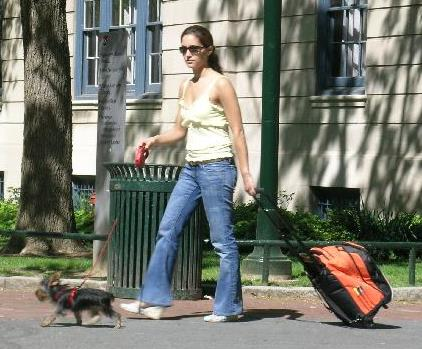

In [15]:
# pick one image from the dataset
img_path = 'PennFudanPed/PNGImages/PennPed00094.png'
img = Image.open(img_path).convert("RGB")
img

In [16]:
import numpy as np
from torchvision.transforms import functional as F

img = F.to_tensor(img)
img = np.expand_dims(img, axis=0)

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [17]:
response = predictor.predict(img)
response

array([{'boxes': tensor([[130.3779,  52.9706, 267.0280, 313.6193],
        [ 49.4477,  22.9902, 291.2352, 325.2440],
        [297.1097, 231.8204, 397.6727, 342.9932]]), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.9803, 0.1799, 0.0784]), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

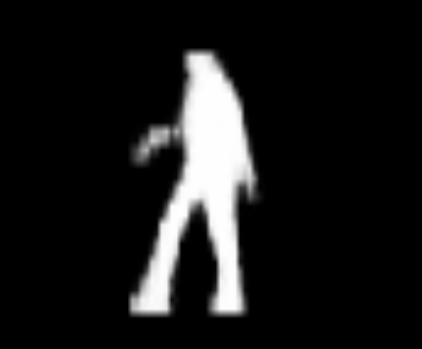

In [18]:
Image.fromarray(response[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

Looks pretty good!

## Cleaning up

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it

In [19]:
predictor.delete_endpoint()